This script was run locally on my laptop. The following six files are necessary to run it:

`/cbica/projects/clinical_dmri_benchmark/results/bundle_stats/<reconstruction>autotrack_<run>.csv`

`<reconstruction>` in [GQI, CSD, SS3T] and `<run>` in [run-01, run-02]


These are the outputs of the following script:
`clinical_dmri_benchmark/analysis/prediction/prep_prediction_files/create_feature_csvs.sh`

In [ ]:
# imports
import pandas as pd
import pingouin as pg
import os
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt

In [13]:
# Define feature to calculate and plot ICC for
# For the manuscript this was run for "total_volume_mm3", "dti_fa" and "md"
FEATURE_OF_INTEREST = "md"

In [17]:
# Read bundle names from file
with open("../../data/bundle_names.txt", "r") as bundle_list:
    bundle_names = []
    # Iterate over the lines of the file
    for line in bundle_list:
        # Remove the newline character at the end of the line
        bundle_name = line.strip()
        # Append the line to the list
        bundle_names.append(bundle_name)

In [18]:
# Read all bundle stats csvs and combine them to one overall dataframe
for i, reconstruction in enumerate(["GQI", "CSD", "SS3T"]):
    for j, run in enumerate(["run-01", "run-02"]):
        bundle_stats = pd.read_csv(os.path.join("/Users/amelie/Datasets/clinical_dmri_benchmark/bundle_stats",
                                                reconstruction + "autotrack_" + run + ".csv"))
        filtered_cols = bundle_stats.filter(like=FEATURE_OF_INTEREST).columns.tolist()
        bundle_stats = bundle_stats[filtered_cols + ["subject_id"]]
        bundle_stats["run"] = run
        bundle_stats["reconstruction"] = reconstruction
        if i + j == 0:
            all_bundle_stats = bundle_stats
        else:
            all_bundle_stats = pd.concat([all_bundle_stats, bundle_stats], ignore_index=True)

In [19]:
# Iterate over the three different reconstructions and all 60 bundles
# calculate ICC and save it in dataframe for plotting
global_df_list = [["bundle", "reconstruction_method", "ICC"]]
for bundle in bundle_names:
    for reconstruction in ["GQI", "CSD", "SS3T"]:
        recon_stats = all_bundle_stats[all_bundle_stats["reconstruction"] == reconstruction]
        icc = pg.intraclass_corr(data=recon_stats, 
                            targets="subject_id", 
                            raters="run", 
                            ratings=bundle + "_" + FEATURE_OF_INTEREST, nan_policy="omit")
        global_df_list.append([bundle, reconstruction, icc[icc["Type"] == "ICC1"]["ICC"].values[0]])
global_df = pd.DataFrame(global_df_list[1:], columns=global_df_list[0])

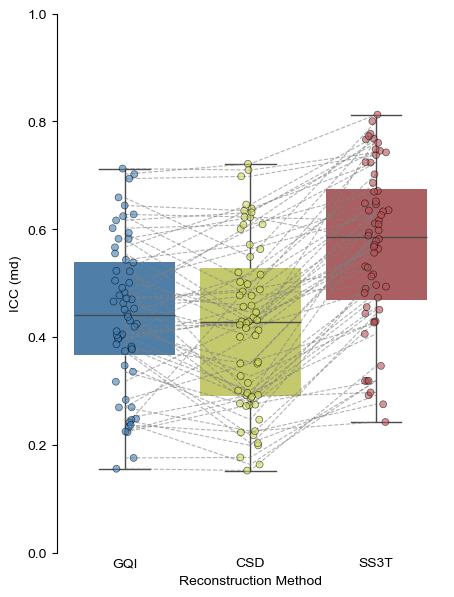

In [20]:
# Plot
# Set figure size, font and color
plt.figure(figsize=(5, 7))
mpl.rcParams["font.family"] = "Arial"
my_palette = sns.color_palette([(64/255, 127/255, 183/255), (208/255, 217/255, 92/255), (182/255, 82/255, 86/255)])
sns.set_palette(my_palette)

bp = sns.boxplot(data=global_df, x="reconstruction_method", y="ICC", hue="reconstruction_method", legend=False, boxprops={"edgecolor": "none"})
bp.set_ylim(0, 1)
sns.stripplot(data=global_df, x="reconstruction_method", y="ICC", hue="reconstruction_method", alpha=0.6, marker="o", edgecolor="black", linewidth=0.5, legend=False)
for bundle, group in global_df.groupby("bundle"):
    plt.plot(group["reconstruction_method"], group["ICC"], linestyle="--", linewidth=0.8, alpha=0.6, color="gray")
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tick_params(axis="x", which="both", length=0)
plt.gca().spines["left"].set_visible(True)
plt.xlabel("Reconstruction Method")
plt.ylabel(f"ICC ({FEATURE_OF_INTEREST})")
plt.savefig(f"../../figures/ICC_{FEATURE_OF_INTEREST}.svg")
plt.show()